SETUP


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp /content/drive/MyDrive/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark as spark

print(spark.__version__)

3.1.1


In [ ]:
#Library ex1
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import csv
import os
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [ ]:
#Library ex2
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from datetime import date
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import os
import shutil
import pandas as pd
from pyspark.sql import SQLContext

In [ ]:
#Library ex3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, explode, split, desc, \
      concat, lit, udf, struct, count, sum, array, concat_ws, size, broadcast,\
      when, array_contains, array_except, expr
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, BooleanType
from itertools import combinations, chain
from concurrent.futures import ThreadPoolExecutor
import subprocess
from pyspark.sql.functions import collect_list, regexp_replace, expr
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import size, length


Ex1

In [ ]:
def f1(file_csv):
  #Đọc file csv bằng hàm rdd
  rdd = sc.textFile(file_csv)
  header = rdd.first()
  data = rdd.filter(lambda line: line != header).map(lambda line: line.split(','))
  #Lấy data từ sau khi đọc file, lọc trùng(distinct) và sắp xếp(sortBy) theo tên
  distinct_items_ordered = data.map(lambda x: x[2]).distinct().sortBy(lambda x: x)
  #Lấy 10 item đầu tiên
  first_10_items = distinct_items_ordered.take(10)
  #Lấy top item cuối cùng, hàm top lấy từ dưới lên nên sẽ phải sắp xếp lại(sort)
  last_10_items = sorted(distinct_items_ordered.top(10))

  ##Hiển thị
  print("First 10 Items Ordered by Name:")
  print('\n'.join(first_10_items))
  print("\nLast 10 Items Ordered by Name:")
  print('\n'.join(last_10_items))

  #Ghi file csv
  output_csv_path = "/content/f1/f1.csv"
  output_directory = "/content/f1/"
  if not os.path.exists(output_directory):
      os.makedirs(output_directory)
  with open(output_csv_path, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['First Item', 'Last Item'])
      for first_item, last_item in zip(first_10_items, last_10_items):
          writer.writerow([first_item, last_item])


f1("/content/baskets.csv")

First 10 Items Ordered by Name:
Instant food products
UHT-milk
abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries

Last 10 Items Ordered by Name:
turkey
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


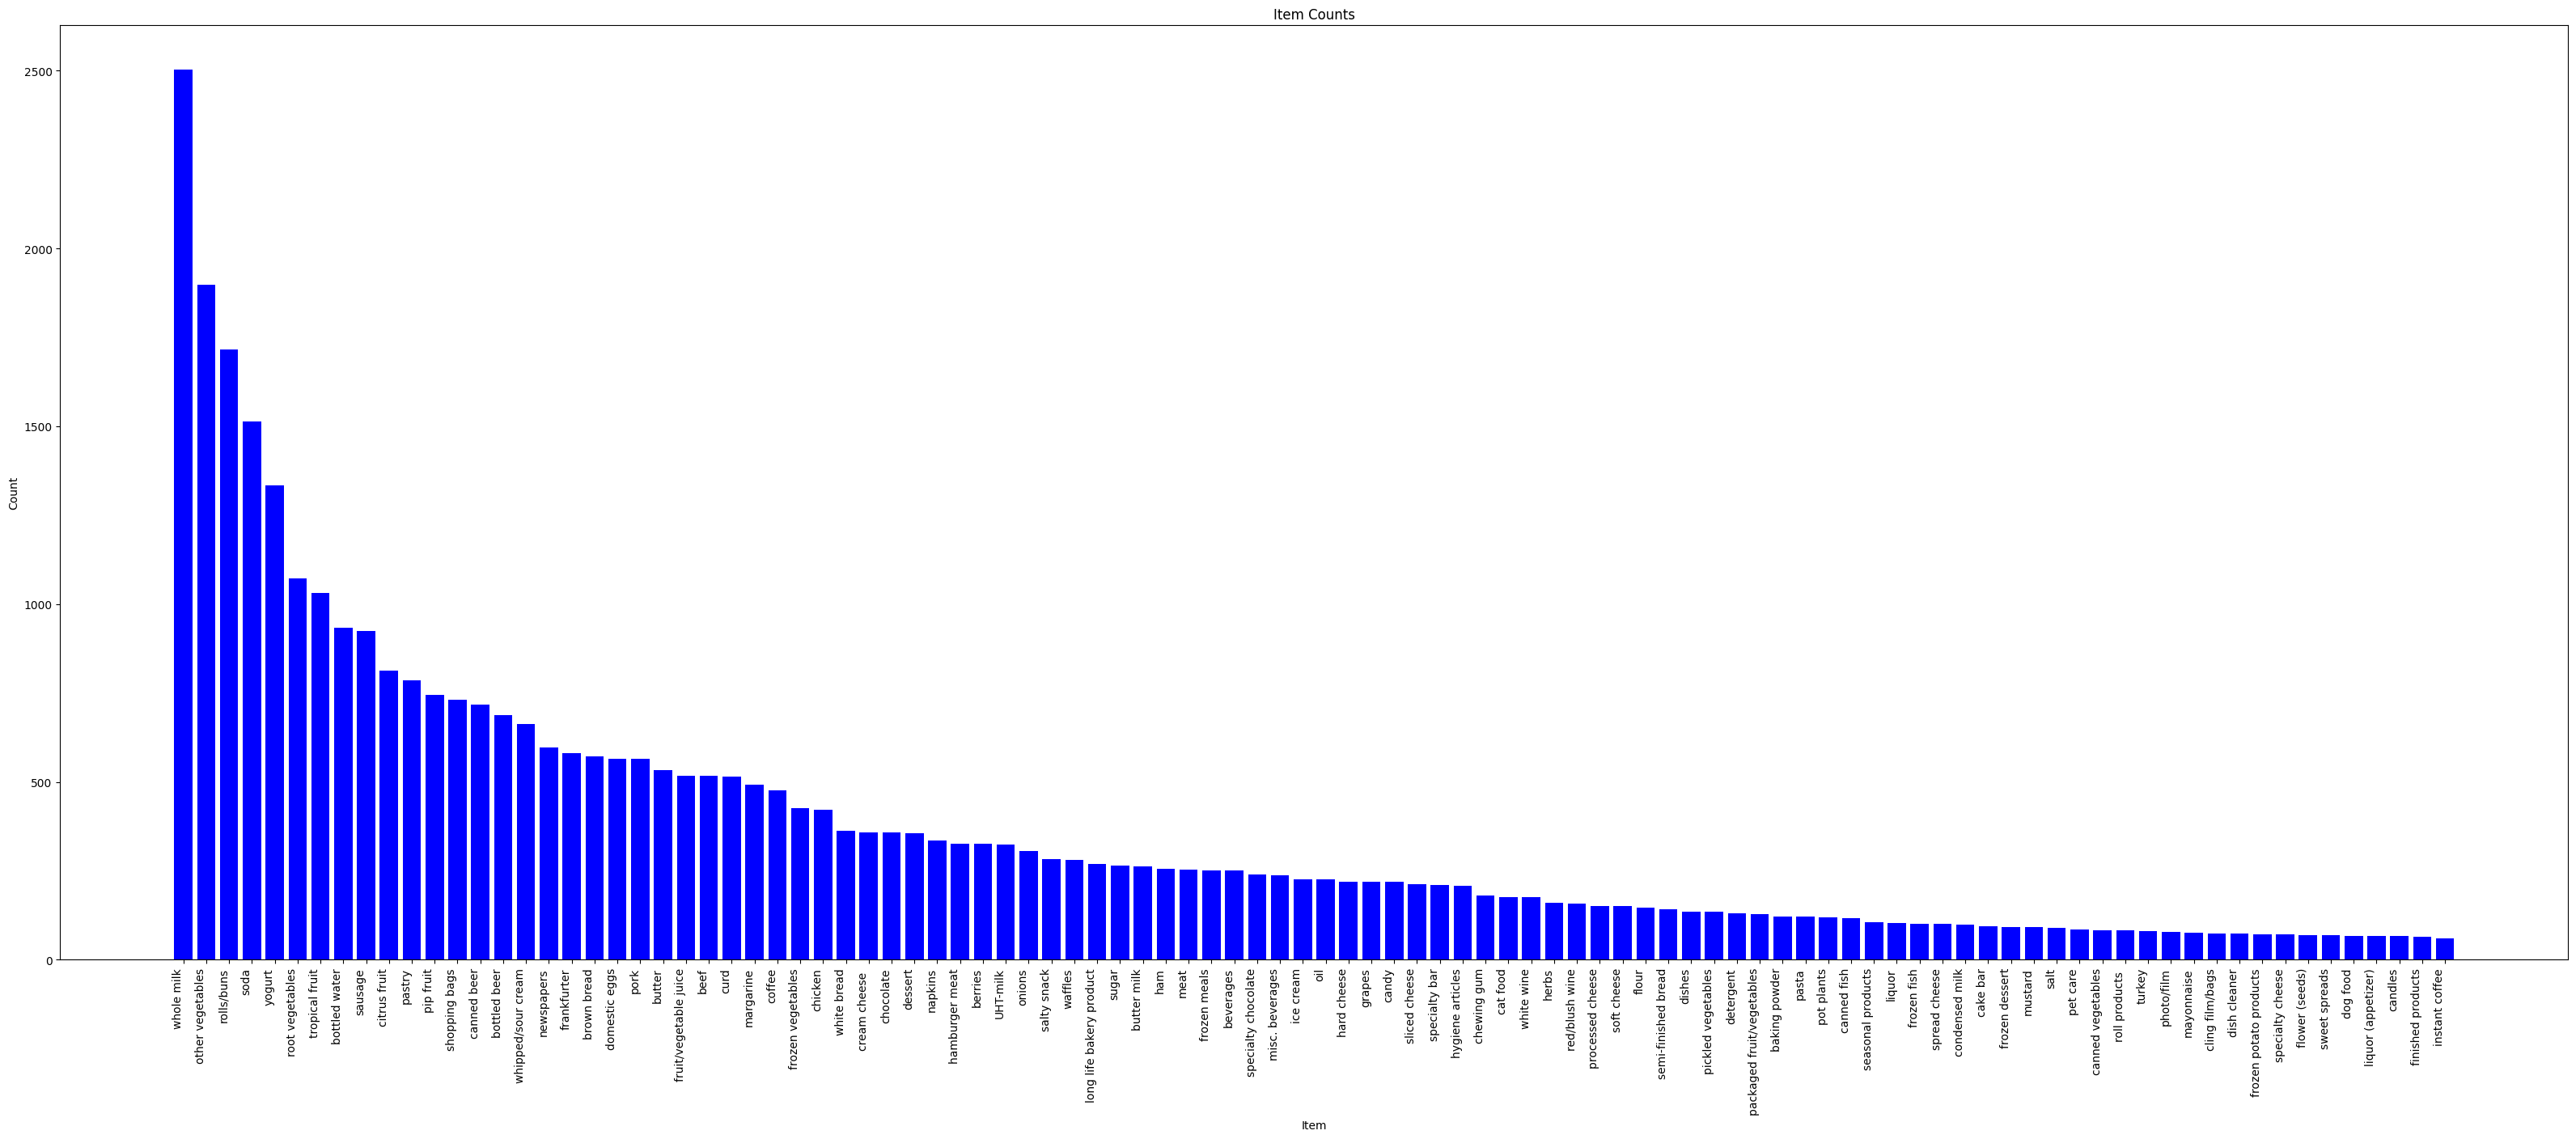

whole milk: 2502
other vegetables: 1898
rolls/buns: 1716
soda: 1514
yogurt: 1334
root vegetables: 1071
tropical fruit: 1032
bottled water: 933
sausage: 924
citrus fruit: 812
pastry: 785
pip fruit: 744
shopping bags: 731
canned beer: 717
bottled beer: 687
whipped/sour cream: 662
newspapers: 596
frankfurter: 580
brown bread: 571
domestic eggs: 566
pork: 566
butter: 534
fruit/vegetable juice: 518
beef: 516
curd: 514
margarine: 491
coffee: 476
frozen vegetables: 425
chicken: 422
white bread: 362
cream cheese : 358
chocolate: 357
dessert: 356
napkins: 335
hamburger meat: 327
berries: 327
UHT-milk: 323
onions: 305
salty snack: 283
waffles: 280
long life bakery product: 269
sugar: 265
butter milk: 263
ham: 256
meat: 254
frozen meals: 252
beverages: 251
specialty chocolate: 240
misc. beverages: 238
ice cream: 227
oil: 225
hard cheese: 220
grapes: 220
candy: 219
sliced cheese: 212
specialty bar: 210
hygiene articles: 208
chewing gum: 181
cat food: 177
white wine: 176
herbs: 159
red/blush wine: 

In [ ]:
def f2(file_path):
    rdd = sc.textFile(file_path)
    header = rdd.first()
    data = rdd.filter(lambda line: line != header).map(lambda line: line.split(','))
    #Lây item
    item_counts = data.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)
    #Sort item theo số lượng
    sorted_item_counts = item_counts.sortBy(lambda x: x[1], ascending=False).collect()

    #trích 100 items để vẽ biểu đồ
    item_chart = item_counts.sortBy(lambda x: x[1], ascending=False).take(100)
    items, counts = zip(*item_chart)

    #Tạo biểu đồ
    fig, ax = plt.subplots(figsize=(40, 15), dpi=100)
    plt.bar(items, counts, color='blue')
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.title('Item Counts')
    plt.xticks(rotation=90, ha='right')
    plt.show()

    #Hiện thị
    for item, count in sorted_item_counts:
      print(f"{item}: {count}")

    #Ghi file csv
    output_csv_path = "/content/f2/f2.csv"
    output_directory = "/content/f2/"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Item', 'Count'])
        for item, count in sorted_item_counts:
            writer.writerow([item, count])

f2("/content/baskets.csv")


2271: 11
1379: 11
3737: 11
4338: 11
2193: 11
1574: 10
3120: 10
3180: 10
2394: 10
4217: 10
2524: 10
4864: 10
3872: 10
3915: 10
1793: 10
4376: 10
1052: 10
1275: 10
1908: 10
3289: 10
3484: 10
3082: 10
3248: 10
1410: 10
3593: 10
2625: 10
4933: 9
3830: 9
1169: 9
3361: 9
2851: 9
3221: 9
4303: 9
1566: 9
2164: 9
4683: 9
1136: 9
2517: 9
3050: 9
2990: 9
1991: 9
4272: 9
3402: 9
4137: 9
1922: 9
4364: 9
2760: 9
1827: 9
3462: 9
2294: 9
2663: 9
3090: 9
3465: 9
4494: 9
2440: 9
2758: 9
1905: 9
1878: 9
4656: 9
1932: 9
1998: 9
4941: 9
1087: 9
1466: 9
2960: 9
4437: 9
2070: 9
3122: 9
3308: 9
1654: 9
2632: 9
4190: 9
4526: 9
4695: 9
3942: 8
1248: 8
4721: 8
4694: 8
1235: 8
1889: 8
4453: 8
1013: 8
2011: 8
2718: 8
3663: 8
4297: 8
2868: 8
4645: 8
2298: 8
3137: 8
2511: 8
2706: 8
3517: 8
3812: 8
3657: 8
4667: 8
4875: 8
2014: 8
1190: 8
4019: 8
3793: 8
4455: 8
1979: 8
2229: 8
1094: 8
1870: 8
3761: 8
1004: 8
2051: 8
1483: 8
3246: 8
1798: 8
2855: 8
2816: 8
4406: 8
4671: 8
4464: 8
4852: 8
4316: 8
2584: 8
3094: 8
2789: 

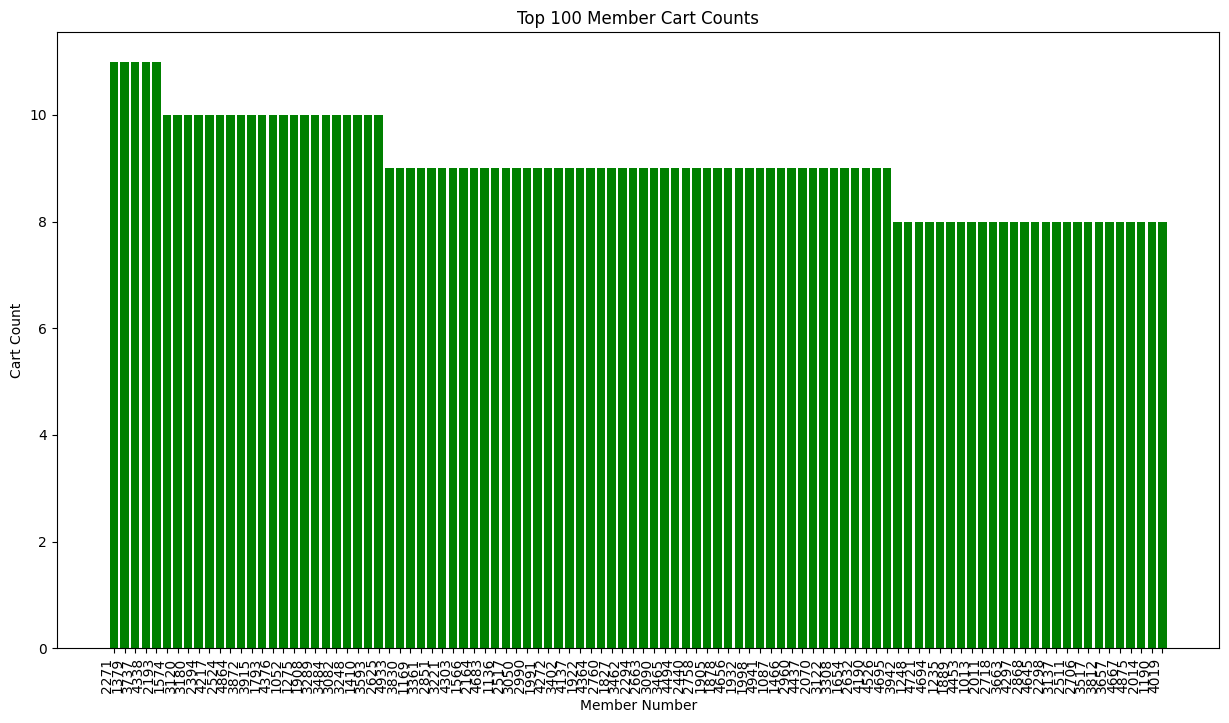

In [ ]:
def f3(file_path):
  rdd = sc.textFile(file_path)
  header = rdd.first()
  data = rdd.filter(lambda line: line != header).map(lambda line: line.split(','))
  #Lấy item cột date + member => nhóm lại thành cart
  member_date = data.map(lambda x: (x[0], x[1]))
  member_cart_counts = member_date.groupByKey().map(lambda x: (x[0], len(set(x[1]))))

  #sắp xếp items trong cart
  sorted_member_cart_counts = member_cart_counts.sortBy(lambda x: x[1], ascending=False)

  #Hiển thị
  for member_number, cart_count in sorted_member_cart_counts.collect():
    print(f"{member_number}: {cart_count}")

  #trích 100 items vẽ biểu đồ
  member_numbers, cart_counts = zip(*sorted_member_cart_counts.take(100))


  # Tạo biểu đồ
  fig, ax = plt.subplots(figsize=(15, 8), dpi=100)
  plt.bar(member_numbers, cart_counts, color='green')
  plt.xlabel('Member Number')
  plt.ylabel('Cart Count')
  plt.title('Top 100 Member Cart Counts')
  plt.xticks(rotation=90, ha='right')

  plt.show()

  #Ghi file csv
  output_csv_path = "/content/f3/f3.csv"
  output_directory = "/content/f3/"
  if not os.path.exists(output_directory):
      os.makedirs(output_directory)
  with open(output_csv_path, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Member Number', 'Cart Count'])
      for member_number, cart_count in sorted_member_cart_counts.collect():
          writer.writerow([member_number, cart_count])

f3("/content/baskets.csv")

In [ ]:
def f4(file_path):
    rdd = sc.textFile(file_path)
    header = rdd.first()
    data = rdd.filter(lambda line: line != header).map(lambda line: line.split(','))

    # lấy cột member + tên
    member_item = data.map(lambda x: (x[0], x[2]))

    # Tính số lượng member_item
    member_item_counts = member_item.groupByKey().map(lambda x: (x[0], len(set(x[1]))))
    member_item_counts_collected = member_item_counts.collect()

    # Tìm hàng lớn nhất
    max_count = sorted(member_item_counts_collected, key=lambda x: x[1], reverse=True)[0][1]

    # Tìm tất cả giá trị trùng với gia trị max
    best_users = [(user[0], user[1]) for user in member_item_counts_collected if user[1] == max_count]

    #Tính ố lượng người mua cho mỗi items
    item_counts = data.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)

    item_counts_collected = item_counts.collect()

    # Tìm tất cả iteems có số lượng người mua cao nhất
    max_buyers_count = sorted(item_counts_collected, key=lambda x: x[1], reverse=True)[0][1]
    best_items = [(item[0], item[1]) for item in item_counts_collected if item[1] == max_buyers_count]

    #hiển thị
    print(f"Users with the most distinct items ({max_count} items):")
    for user in best_users:
        print(f"User {user[0]}: {user[1]} items")

    print(f"\nItems bought by the most users ({max_buyers_count} users):")
    for item in best_items:
        print(f"Item {item[0]}: {item[1]} users")

    # Ghi file
    output_directory = "/content/f4/"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    output_csv_path_users = os.path.join(output_directory, "f4_1.csv")
    with open(output_csv_path_users, mode='w', newline='') as file_users:
        writer_users = csv.writer(file_users)
        writer_users.writerow(['User', 'Count'])
        for user in best_users:
            writer_users.writerow([user[0], user[1]])
    output_csv_path_items = os.path.join(output_directory, "f4_2.csv")
    with open(output_csv_path_items, mode='w', newline='') as file_items:
        writer_items = csv.writer(file_items)
        writer_items.writerow(['Item', 'Count'])
        for item in best_items:
            writer_items.writerow([item[0], item[1]])

f4("/content/baskets.csv")

Users with the most distinct items (26 items):
User 2051: 26 items
User 1379: 26 items

Items bought by the most users (2502 users):
Item whole milk: 2502 users


Ex2

In [ ]:

sqlc = SQLContext(sc)
path = '/content/baskets.csv'
df = sqlc.read.csv(path,header=True)
df.show()
df.printSchema()

+-------------+----------+--------------------+----+-----+---+-----------+
|Member_number|      Date|     itemDescription|year|month|day|day_of_week|
+-------------+----------+--------------------+----+-----+---+-----------+
|         1249|01/01/2014|        citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|              coffee|2014|    1|  1|          2|
|         1381|01/01/2014|                curd|2014|    1|  1|          2|
|         1381|01/01/2014|                soda|2014|    1|  1|          2|
|         1440|01/01/2014|    other vegetables|2014|    1|  1|          2|
|         1440|01/01/2014|              yogurt|2014|    1|  1|          2|
|         1659|01/01/2014| specialty chocolate|2014|    1|  1|          2|
|         1659|01/01/2014|   frozen vegetables|2014|    1|  1|          2|
|         1789|01/01/2014|      hamburger meat|2014|    1|  1|          2|
|         1789|01/01/2014|             candles|2014|    1|  1|          2|
|         1922|01/01/2014

In [ ]:
#Lấy data + sort theo date
df = df.withColumn("Date", F.to_date(df["Date"], "dd/MM/yyyy"))
df = df.orderBy("Date")
#Lấy baskets
Baskets = df.groupBy("Member_number", "Date").agg(
    F.collect_list("itemDescription").alias("items")
)
Baskets = Baskets.withColumn("items",expr("array_distinct(items)"))
Baskets = Baskets.withColumn("items", F.concat_ws(", ", "items"))
Baskets.show(truncate=False)

+-------------+----------+-----------------------------------------------+
|Member_number|Date      |items                                          |
+-------------+----------+-----------------------------------------------+
|1249         |2014-01-01|citrus fruit, coffee                           |
|1381         |2014-01-01|curd, soda                                     |
|1440         |2014-01-01|other vegetables, yogurt                       |
|1659         |2014-01-01|specialty chocolate, frozen vegetables         |
|1789         |2014-01-01|hamburger meat, candles                        |
|1922         |2014-01-01|tropical fruit, other vegetables               |
|2226         |2014-01-01|sausage, bottled water                         |
|2237         |2014-01-01|bottled water, Instant food products           |
|2351         |2014-01-01|cleaner, shopping bags                         |
|2542         |2014-01-01|sliced cheese, bottled water                   |
|2610         |2014-01-01

In [ ]:
for i in Baskets.collect():
  print(i)

Streaming output truncated to the last 5000 lines.
Row(Member_number='3074', Date=datetime.date(2015, 4, 13), items='whole milk, margarine')
Row(Member_number='3339', Date=datetime.date(2015, 4, 13), items='meat, margarine')
Row(Member_number='3353', Date=datetime.date(2015, 4, 13), items='sausage, yogurt, baking powder')
Row(Member_number='3405', Date=datetime.date(2015, 4, 13), items='beef, ice cream, rolls/buns, pip fruit, whole milk, fruit/vegetable juice, UHT-milk')
Row(Member_number='3629', Date=datetime.date(2015, 4, 13), items='chicken, tropical fruit')
Row(Member_number='3885', Date=datetime.date(2015, 4, 13), items='chocolate, seasonal products, rolls/buns')
Row(Member_number='4177', Date=datetime.date(2015, 4, 13), items='frankfurter, whole milk, grapes, butter, semi-finished bread')
Row(Member_number='4357', Date=datetime.date(2015, 4, 13), items='sausage, chicken, canned beer, pip fruit')
Row(Member_number='4389', Date=datetime.date(2015, 4, 13), items='white wine, whole m

In [ ]:
output_folder = "Baskets"
Baskets.coalesce(1).write.csv(output_folder, header=True, mode="overwrite")

In [ ]:
numBaskets = dict(Baskets.withColumn("Date", to_date("Date", "dd/MM/yyyy")) \
                                       .groupBy("Date") \
                                       .count() \
                                       .orderBy("Date") \
                                       .collect())
#In kết quả
print(len(numBaskets))
print(list(numBaskets.values()))

728
[21, 29, 24, 28, 20, 13, 16, 19, 28, 23, 15, 18, 20, 24, 13, 18, 20, 22, 23, 24, 24, 17, 30, 19, 18, 14, 22, 26, 16, 27, 28, 25, 20, 26, 28, 26, 26, 27, 30, 27, 18, 21, 23, 21, 24, 21, 24, 25, 26, 18, 23, 21, 29, 18, 27, 21, 31, 25, 20, 21, 25, 23, 34, 23, 27, 16, 22, 24, 19, 20, 27, 19, 18, 21, 20, 18, 19, 16, 20, 23, 16, 16, 19, 21, 18, 23, 24, 18, 21, 19, 17, 28, 26, 23, 20, 20, 10, 22, 29, 19, 16, 16, 34, 18, 26, 26, 27, 20, 26, 19, 22, 25, 23, 28, 24, 16, 20, 17, 16, 24, 24, 16, 16, 21, 17, 18, 24, 22, 23, 19, 35, 17, 25, 21, 27, 13, 21, 24, 25, 24, 16, 18, 25, 20, 27, 24, 22, 24, 30, 35, 29, 23, 20, 17, 19, 21, 31, 22, 16, 27, 19, 13, 25, 30, 27, 17, 22, 15, 18, 26, 25, 22, 29, 18, 23, 23, 29, 24, 20, 12, 20, 27, 16, 15, 21, 20, 29, 33, 23, 30, 22, 31, 12, 27, 21, 21, 17, 25, 23, 16, 23, 27, 26, 24, 15, 18, 27, 21, 23, 20, 22, 25, 22, 19, 21, 23, 29, 23, 19, 16, 18, 21, 21, 18, 21, 27, 18, 28, 26, 18, 21, 21, 23, 23, 17, 20, 22, 25, 20, 39, 16, 17, 21, 21, 23, 13, 13, 27, 20,

In [ ]:
numBaskets = pd.DataFrame.from_dict(numBaskets, orient='index', columns=['Count'])
print(numBaskets)

            Count
2014-01-01     21
2014-01-02     29
2014-01-03     24
2014-01-04     28
2014-01-05     20
...           ...
2015-12-26     15
2015-12-27     21
2015-12-28     19
2015-12-29     22
2015-12-30     19

[728 rows x 1 columns]


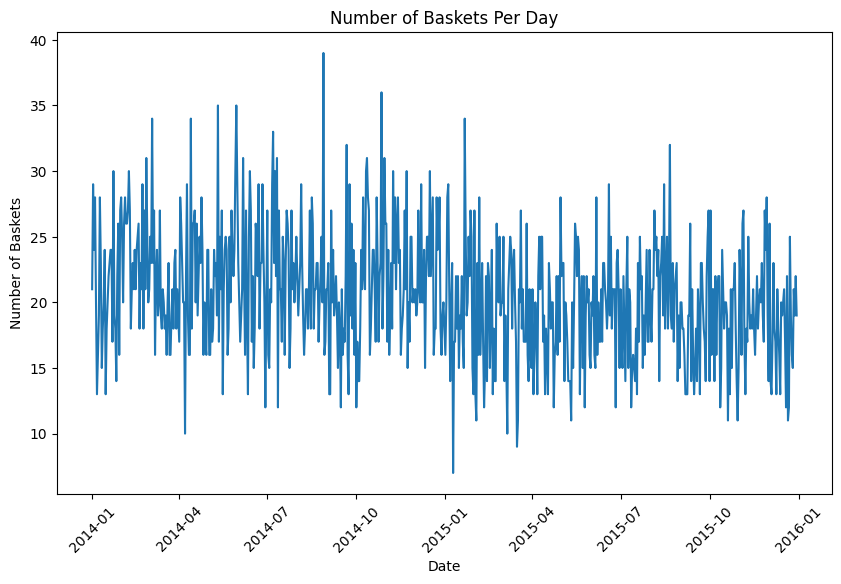

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(numBaskets.index, numBaskets['Count'])
plt.title("Number of Baskets Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Baskets")
plt.xticks(rotation=45)
plt.show()

EX3

PCY

In [ ]:
class PCY:
  def __init__(self, file_path, s, c):
    """
    Constructor method

    Parameters:
      file_path is the file path to csv file \n
      s is the minimum support \n
      c is the minimun confidence
    """

    self.df = sqlc.read.csv(file_path, header=True)
    self.s = s
    self.c = c


  def get_frequent_items(self, df_count):
    """
    Get frequent items \n
    Hàm dùng để tìm các item phổ biến

    Parameters:
      df_count is the number row of df \n
      df_count là số lượng dòng của df

    Returns:
      The frequent items in DataFrame \n
      Các item phổ biến dưới dạng DataFrame
    """

    items_df = self.df.withColumn("items", split(self.df["items"], ", "))
    items_df = items_df.select(explode("items").alias("item"))
    item_support_df = items_df.groupBy("item").count()
    item_support_df = item_support_df.withColumn("support",
                                                 col("count") / df_count)
    frequent_items_df = item_support_df.filter(col("support") >= self.s)
    frequent_items_df = frequent_items_df.drop("count")
    return frequent_items_df

  def generate_frequent_itemsets(self, frequent_items_df, df_count):
    """
    Generate frequent possible itemsets \n
    Hàm dùng để tạo các itemset phổ biến

    Parameters:
      frequent_items_df is the frequent items in DataFrame \n
      frequent_items_df là các item phổ biến dưới dạng DataFrame

    Returns:
      The frequent itemsets in DataFrame \n
      (Các tập phổ biến dưới dạng DataFrame)
    """

    # Lấy ra cột items từ req 2
    transactions_rdd = self.df.select("items").rdd.map(lambda row:
                                                       set(row[0].split(", ")))

    # Tạo ra các itemset có từ transactions
    itemsets = transactions_rdd \
      .flatMap(lambda transaction: \
                            [itemset for r in range(2, len(transaction) + 1) \
                                for itemset in combinations(transaction, r)]) \
      .map(lambda itemset: (tuple(sorted(itemset)), 1)) \
      .reduceByKey(lambda a, b: a + b)

    itemsets_df = itemsets.map(lambda x: (", ".join(x[0]), x[1]))\
                          .toDF(["itemset", "support"])


    # Tính toán support cho itemset
    itemsets_df = itemsets_df.withColumn("support", col("support") / df_count)

    # Hash function
    num_buckets = 500   # Số lượng bucket
    hash_expr = expr(f"mod(hash(itemset), {num_buckets})")

    # Hash các itemset
    buckets_df = itemsets_df.withColumn("bucket", hash_expr)
    buckets_df = buckets_df.rdd.map(lambda line: (line[2], line[0], line[1]))
    buckets_df = buckets_df.toDF(["bucket", "itemset", "support"])

    # Show bucket df
    # buckets_df.show()

    # Tính tổng support cho mỗi bucket
    buckets_count_df = buckets_df.groupBy("bucket") \
                          .agg(sum("support").alias("total_support"))

    # Lọc ra các bucket có support >= minimum support
    buckets_df_filter = buckets_count_df.filter(col("total_support") >= self.s)

    # Lấy các itemset từ các bucket đã lọc
    itemsets_df_filter = buckets_df_filter\
          .join(broadcast(buckets_df),
                buckets_df_filter.bucket == buckets_df.bucket) \
          .select("itemset", "support")

    # Lọc các itemset >= minimum support
    itemsets_df_filter = itemsets_df_filter.filter(col("support") >= self.s)

    return itemsets_df_filter

  def find_association_rules(self, frequent_itemsets_df, frequent_items_df):
    """
    Find association rules \n
    Hàm tìm quy luật kết hợp

    Parameters:
      frequent_itemsets_df is the frequent itemsets in DataFrame \n
      (frequent_itemsets_df là các tập phổ biến dưới dạng DataFrame)
      frequent_items_df is the frequent items in DataFrame \n
      (frequent_items_df là các item phổ biến dưới dạng DataFrame)

    Returns:
      The association rules in DataFrame \n
      (Các quy luật kết hợp dưới dạng DataFrame)
    """

    # Thực hiện gộp các frequent item vào chung
    all_frequent_itemsets_df = frequent_itemsets_df.union(frequent_items_df)

    # Đổi tên trước khi join
    left_frequent_itemsets_df = all_frequent_itemsets_df \
                        .withColumnRenamed("itemset", "left_itemset") \
                        .withColumnRenamed("support", "left_support")
    right_frequent_itemsets_df = all_frequent_itemsets_df \
                        .withColumnRenamed("itemset", "right_itemset") \
                        .withColumnRenamed("support", "right_support")

    # Cột itemset ban đầu là string, đổi sang list
    left_frequent_itemsets_df = left_frequent_itemsets_df \
                .withColumn("left_itemset", \
                    split(left_frequent_itemsets_df["left_itemset"], ", "))
    right_frequent_itemsets_df = right_frequent_itemsets_df \
                .withColumn("right_itemset", \
                    split(right_frequent_itemsets_df["right_itemset"], ", "))

    # Lọc các itemset bên trái có ít phần tử hơn bên phải
    # Bên trái là subset của bên phải
    combination_itemsets_df = left_frequent_itemsets_df \
            .join(broadcast(right_frequent_itemsets_df), \
                size(left_frequent_itemsets_df["left_itemset"]) < \
                size(right_frequent_itemsets_df["right_itemset"]))

    # Lọc lần 2 để loại bỏ các itemset bên trái không phải là subset bên phải
    combination_itemsets_df = combination_itemsets_df.filter(
        size(array_except(combination_itemsets_df["left_itemset"], \
                          combination_itemsets_df["right_itemset"])) == 0)
    combination_itemsets_df = combination_itemsets_df.withColumn("confidence",\
                                    col("right_support") / col("left_support"))

    # Lọc các association rule thỏa điều kiện
    combination_itemsets_df = combination_itemsets_df \
                .filter(col("confidence") >= self.c)

    # Lọc để lấy consequent
    combination_itemsets_df = combination_itemsets_df \
                .withColumn("right_itemset", \
                      array_except(combination_itemsets_df["right_itemset"], \
                                   combination_itemsets_df["left_itemset"]))

    # Đổi tên các column lại
    association_rules_df = combination_itemsets_df \
                .select("left_itemset", "right_itemset", "confidence") \
                .withColumnRenamed("left_itemset", "antecedent") \
                .withColumnRenamed("right_itemset", "consequent")

    return association_rules_df

  def save_to_csv(self, save_df, name_save):
    if os.path.exists(f'{name_save}.csv'):
        subprocess.call(f"rm -r {name_save}.csv", shell=True)
    save_df.toPandas().to_csv(f"{name_save}.csv", index=False)


  def run(self):
    # Lấy số lượng dòng của df
    df_count = self.df.count()

    # Gọi hàm để tìm frequent items
    frequent_items_df = self.get_frequent_items(df_count)

    # Gọi hàm để tìm frequent itemsets
    frequent_itemsets_df = self.generate_frequent_itemsets(frequent_items_df, \
                                                           df_count)

    # Tách itemset từ string thành list
    itemsets_array_df = frequent_itemsets_df \
          .withColumn("itemset_array", \
                      split(frequent_itemsets_df["itemset"], ", "))

    # Lọc ra các cặp phổ biến từ itemsets
    frequent_pairs_df = itemsets_array_df \
          .filter(size(itemsets_array_df["itemset_array"]) == 2) \
          .drop("itemset_array") \
          .withColumnRenamed("itemset", "pair")

    # In ra màn hình
    print(f"Có {frequent_pairs_df.count()} cặp phổ biến")
    print("Danh sách các cặp phổ biến")
    frequent_pairs_df.show(truncate=False)

    # Gọi hàm để tìm association rule
    association_rules_df = self.find_association_rules(frequent_itemsets_df, \
                                                             frequent_items_df)

    # In ra màn hình
    print("Danh sách association rules")
    association_rules_df.show(truncate=False)

    # Lưu file, chạy song song 2 task lưu file
    with ThreadPoolExecutor() as executor:
      executor.submit(self.save_to_csv, frequent_pairs_df, \
                      "pcy_frequent_pairs")
      executor.submit(self.save_to_csv, association_rules_df, \
                      "pcy_association_rules")

## Thanh Test


In [ ]:
file_path = '/content/Baskets/part-00000-9ec2c961-db52-4d11-87df-60a701d17060-c000.csv'
s = 0.001
c = .15
pcy = PCY(file_path, s, c)
pcy.run()

Có 588 cặp phổ biến
Danh sách các cặp phổ biến
+---------------------------------+---------------------+
|pair                             |support              |
+---------------------------------+---------------------+
|citrus fruit, coffee             |0.0013366303548753592|
|canned beer, pip fruit           |0.001603956425850431 |
|frozen vegetables, tropical fruit|0.0010693042839002875|
|chocolate, citrus fruit          |0.0010693042839002875|
|pork, tropical fruit             |0.0015371249081066632|
|fruit/vegetable juice, pastry    |0.0014702933903628951|
|citrus fruit, tropical fruit     |0.0028737552629820224|
|newspapers, whipped/sour cream   |0.0015371249081066632|
|coffee, shopping bags            |0.001403461872619127 |
|ice cream, soda                  |0.0012029673193878234|
|domestic eggs, pastry            |0.0013366303548753592|
|margarine, soda                  |0.0026064291920069507|
|curd, whole milk                 |0.004143554100113613 |
|canned beer, yogurt     